In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym
import numpy as np
from collections import deque

In [2]:
# hyperparameters
# discount factor for future utilities
DISCOUNT_FACTOR = 0.99

# number of episodes to run
NUM_EPISODES = 10000

# mat steps per episode
MAX_STEPS = 10000

# score agent needs for environment to be solved
SOLVED_SCORE = 195

lr = 0.001

print_step = 100

# device to run model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class actor_net(nn.Module):
    def __init__(self, observation_space, action_space):
        super(actor_net, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)

        # get softmax for a probability distribution
        action_probs = F.softmax(actions, dim = 1)

        return action_probs

    def select_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0).to(device)
        action_probs = self.forward(s)

        # state = s.detach()
        m = Categorical(action_probs)
        action = m.sample()

        return action.item(), m.log_prob(action), m

In [4]:
class critic_net(nn.Module):
    def __init__(self, observation_space):
        super(critic_net, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)

        # get state value
        state_value = self.output_layer(x)

        return state_value

In [5]:
# Make environment
env = gym.make("CartPole-v1")

# Initialize actor and critic
actor = actor_net(env.observation_space.shape[0], env.action_space.n).to(device)
critic = critic_net(env.observation_space.shape[0]).to(device)

# Initialize optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr = lr)
critic_optimizer = optim.Adam(critic.parameters(), lr = lr)

In [6]:
scores = []
recent_score = deque(maxlen = 100)

for episode in range(NUM_EPISODES):
    # init variables
    state, _ = env.reset()
    done = False
    score = 0
    I = 1

    # run episode, update online
    for step in range(MAX_STEPS):

        # get action and log probability
        action, log_prob, m = actor.select_action(state)

        # step with action
        next_state, reward, done, trancated, _ = env.step(action)

        # update episode score
        score += reward

        # get state value
        state_val_current = critic(torch.from_numpy(state).float().unsqueeze(0).to(device))
        state_val_next = critic(torch.from_numpy(next_state).float().unsqueeze(0).to(device))

        # if terminal state, next state value is 0
        if done:
            state_val_next = torch.tensor([0]).float().unsqueeze(0).to(device)

        # calculate value function loss with MSE
        # val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * state_val_next, state_val_current)
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * state_val_next.detach(), state_val_current)

        # val_loss *= I

        # calculate policy loss
        entropy = m.entropy()

        advantage = reward + DISCOUNT_FACTOR * state_val_next.item() - state_val_current.item()
        policy_loss = 0.1 * (-log_prob * advantage) + 0.01 * entropy

        # Backpropagate policy
        actor_optimizer.zero_grad()
        policy_loss.backward(retain_graph = True)
        actor_optimizer.step()

        # Backpropagate value
        critic_optimizer.zero_grad()
        val_loss.backward()
        critic_optimizer.step()

        if done:
            break

        # move into new state, discount I
        state = next_state
        # I *= DISCOUNT_FACTOR
    
    # append episode score
    scores.append(score)
    recent_score.append(score)

    if (episode % print_step == 0):
        print(f"Episode {episode}, score: {score}")

    # early stopping if we meet solved score goal
    if (np.array(recent_score).mean() >= SOLVED_SCORE):
        break

Episode 0, score: 10.0
Episode 100, score: 9.0
Episode 200, score: 12.0
Episode 300, score: 34.0
Episode 400, score: 91.0
Episode 500, score: 44.0
Episode 600, score: 65.0


KeyboardInterrupt: 

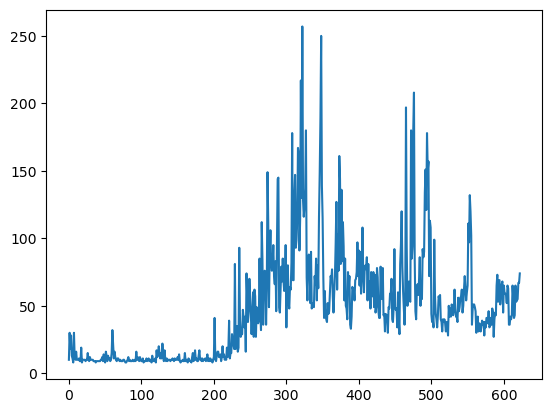

In [7]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.show()

In [8]:
import time
env = gym.make("CartPole-v1", render_mode = "human")
state, info = env.reset()

for i in range(500):
    action, lp, m = actor.select_action(state)
    state, reward, done, truncated, _ = env.step(action)

    env.render()

    time.sleep(0.01)

    if done:
        state, info = env.reset()

env.close()